## Deep Learning models trained to figure out sentiment in tweets/x's

In [1]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud

import nltk


#import gensim
from sklearn.model_selection import train_test_split
#import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

Done


In [2]:
data=pd.read_csv('Tweets.csv')

In [3]:
data.head()
data.tail()

,textID,text,selected_text,sentiment
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive
27480,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral


In [4]:
data['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [5]:
data.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11118,11117,11111
positive,8582,8582,5537


### Cleaning 


In [6]:
data = data[['selected_text', 'sentiment']]
data.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [7]:
data["selected_text"].fillna("No content", inplace = True)

In [8]:
def clean_text(data):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    data = re.sub('\S*@\S*\s?', '', data)
    data = re.sub('\s+', ' ', data)
    data = re.sub("\'", "", data)
    return data

In [9]:
temp=[]
data_to_list = data['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(clean_text(data_to_list[i]))
list(temp[:5])


['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

In [11]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [12]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [14]:
words = []
for i in range(len(data_words)):
    words.append(detokenize(data_words[i]))
print(words[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [16]:
data['processed_text'] = words 

### Label Encoding 

In [18]:
labels = np.array(data['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3)
del y

In [19]:
labels = labels.astype('float32')

In [21]:
import keras
print(keras.__version__)

3.11.0


### sequencing and splitting 

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['processed_text'])
sequences = tokenizer.texts_to_sequences(data['processed_text'])
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [26]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


### Model building

In [27]:
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=42)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


In [30]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("best_model1.h5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5864 - loss: 0.9134
Epoch 1: val_accuracy improved from None to 0.74269, saving model to best_model1.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6398 - loss: 0.8215 - val_accuracy: 0.7427 - val_loss: 0.6681
Epoch 2/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7514 - loss: 0.6252
Epoch 2: val_accuracy improved from 0.74269 to 0.79115, saving model to best_model1.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.7618 - loss: 0.5990 - val_accuracy: 0.7912 - val_loss: 0.5408
Epoch 3/70
643/645 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8001 - loss: 0.5187
Epoch 3: val_accuracy improved from 0.79115 to 0.80978, saving model to best_model1.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.7988 - loss: 0.5175 - val_accuracy: 0.8098 - val_loss: 0.5024
Epoch 4/70
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8167 - loss: 0.4762
Epoch 4: val_accuracy improved from 0.80978 to 0.82011, saving model to best_model1.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.8164 - loss: 0.4805 - val_accuracy: 0.8201 - val_loss: 0.4785
Epoch 5/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8271 - loss: 0.4597
Epoch 5: val_accuracy improved from 0.82011 to 0.82201, saving model to best_model1.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8267 - loss: 0.4571 - val_accuracy: 0.8220 - val_loss: 0.4685
Epoch 6/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8378 - loss: 0.4379
Epoch 6: val_accuracy improved from 0.82201 to 0.82695, saving model to best_model1.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.8349 - loss: 0.4408 - val_accuracy: 0.8270 - val_loss: 0.4635
Epoch 7/70
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8445 - loss: 0.4199
Epoch 7: val_accuracy did not improve from 0.82695
645/645 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.8407 - loss: 0.4268 - val_accuracy: 0.8249 - val_loss: 0.4653
Epoch 8/70
643/645 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8458 - loss: 0.4140
Epoch 8: val_accuracy improved from 0.82695 to 0.83176, saving model to best_model1.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.8438 - loss: 0.4166 - val_accuracy: 0.8318 - val_loss: 0.4503
Epoch 9/70
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8475 - loss: 0.4031
Epoch 9: val_accuracy did not improve from 0.83176
645/645 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.8495 - loss: 0.4063 - val_accuracy: 0.8284 - val_loss: 0.4569
Epoch 10/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8549 - loss: 0.4017
Epoch 10: val_accuracy improved from 0.83176 to 0.83234, saving model to best_model1.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8551 - loss: 0.3992 - val_accuracy: 0.8323 - val_loss: 0.4478
Epoch 11/70
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8570 - loss: 0.3958
Epoch 11: val_accuracy improved from 0.83234 to 0.83670, saving model to best_model1.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8556 - loss: 0.3918 - val_accuracy: 0.8367 - val_loss: 0.4477
Epoch 12/70
643/645 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8580 - loss: 0.3897
Epoch 12: val_accuracy did not improve from 0.83670
645/645 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8567 - loss: 0.3875 - val_accuracy: 0.8367 - val_loss: 0.4405
Epoch 13/70
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8613 - loss: 0.3822
Epoch 13: val_accuracy did not improve from 0.83670
645/645 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.8613 - loss: 0.3815 - val_accuracy: 0.8320 - val_loss: 0.4496
Epoch 14/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8658 - loss: 0.3682
Epoch 14: val_accuracy improved from 0.83670 to 0.83932, saving model to best_model1.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8623 - loss: 0.3759 - val_accuracy: 0.8393 - val_loss: 0.4371
Epoch 15/70
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8724 - loss: 0.3533
Epoch 15: val_accuracy improved from 0.83932 to 0.84122, saving model to best_model1.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8648 - loss: 0.3694 - val_accuracy: 0.8412 - val_loss: 0.4365
Epoch 16/70
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8681 - loss: 0.3543
Epoch 16: val_accuracy did not improve from 0.84122
645/645 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.8661 - loss: 0.3630 - val_accuracy: 0.8374 - val_loss: 0.4384
Epoch 17/70
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8683 - loss: 0.3622
Epoch 17: val_accuracy did not improve from 0.84122
645/645 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.8664 - loss: 0.3617 - val_accuracy: 0.8392 - val_loss: 0.4350
Epoch 18/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8695 - loss: 0.3581
Epoch 18: val_accuracy did not improve from 0.84122
645/645 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.8695 - loss: 0.3590 - val_accuracy: 0.8392 - val_loss: 0.4387
Epoch 19/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8714 - loss: 0.3559
Epoch 19: val_ac

645/645 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.8754 - loss: 0.3437 - val_accuracy: 0.8415 - val_loss: 0.4332
Epoch 23/70
643/645 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8743 - loss: 0.3439
Epoch 23: val_accuracy did not improve from 0.84151
645/645 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8767 - loss: 0.3405 - val_accuracy: 0.8367 - val_loss: 0.4434
Epoch 24/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8834 - loss: 0.3274
Epoch 24: val_accuracy did not improve from 0.84151
645/645 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8782 - loss: 0.3362 - val_accuracy: 0.8405 - val_loss: 0.4337
Epoch 25/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8793 - loss: 0.3350
Epoch 25: val_accuracy did not improve from 0.84151
645/645 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8782 - loss: 0.3347 - val_accuracy: 0.8393 - val_loss: 0.4323
Epoch 26/70
643/645 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8848 - loss: 0.3234
Epoch 26: val_ac

645/645 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.8802 - loss: 0.3261 - val_accuracy: 0.8441 - val_loss: 0.4311
Epoch 28/70
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8812 - loss: 0.3271
Epoch 28: val_accuracy did not improve from 0.84413
645/645 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.8822 - loss: 0.3275 - val_accuracy: 0.8402 - val_loss: 0.4358
Epoch 29/70
643/645 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8823 - loss: 0.3259
Epoch 29: val_accuracy did not improve from 0.84413
645/645 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.8807 - loss: 0.3254 - val_accuracy: 0.8379 - val_loss: 0.4401
Epoch 30/70
643/645 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8814 - loss: 0.3203
Epoch 30: val_accuracy did not improve from 0.84413
645/645 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.8810 - loss: 0.3241 - val_accuracy: 0.8403 - val_loss: 0.4343
Epoch 31/70
643/645 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8846 - loss: 0.3172
Epoch 31: val_ac

In [31]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.h5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=60,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/60
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5848 - loss: 0.8904
Epoch 1: val_accuracy improved from None to 0.75506, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.6479 - loss: 0.7970 - val_accuracy: 0.7551 - val_loss: 0.6383
Epoch 2/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7604 - loss: 0.6010
Epoch 2: val_accuracy improved from 0.75506 to 0.79683, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.7717 - loss: 0.5761 - val_accuracy: 0.7968 - val_loss: 0.5266
Epoch 3/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8015 - loss: 0.5057
Epoch 3: val_accuracy improved from 0.79683 to 0.80963, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.8051 - loss: 0.5038 - val_accuracy: 0.8096 - val_loss: 0.4957
Epoch 4/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8207 - loss: 0.4753
Epoch 4: val_accuracy improved from 0.80963 to 0.82040, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.8177 - loss: 0.4761 - val_accuracy: 0.8204 - val_loss: 0.4778
Epoch 5/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8279 - loss: 0.4588
Epoch 5: val_accuracy improved from 0.82040 to 0.82230, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.8307 - loss: 0.4515 - val_accuracy: 0.8223 - val_loss: 0.4706
Epoch 6/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8350 - loss: 0.4421
Epoch 6: val_accuracy did not improve from 0.82230
645/645 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.8352 - loss: 0.4394 - val_accuracy: 0.8217 - val_loss: 0.4824
Epoch 7/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8390 - loss: 0.4324
Epoch 7: val_accuracy improved from 0.82230 to 0.82914, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.8421 - loss: 0.4271 - val_accuracy: 0.8291 - val_loss: 0.4594
Epoch 8/60
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8509 - loss: 0.4040
Epoch 8: val_accuracy improved from 0.82914 to 0.83132, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.8487 - loss: 0.4130 - val_accuracy: 0.8313 - val_loss: 0.4518
Epoch 9/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8472 - loss: 0.4046
Epoch 9: val_accuracy did not improve from 0.83132
645/645 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.8495 - loss: 0.4040 - val_accuracy: 0.8303 - val_loss: 0.4563
Epoch 10/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8537 - loss: 0.3902
Epoch 10: val_accuracy did not improve from 0.83132
645/645 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.8524 - loss: 0.3930 - val_accuracy: 0.8286 - val_loss: 0.4509
Epoch 11/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8592 - loss: 0.3834
Epoch 11: val_accuracy did not improve from 0.83132
645/645 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.8572 - loss: 0.3879 - val_accuracy: 0.8313 - val_loss: 0.4461
Epoch 12/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8587 - loss: 0.3746
Epoch 12: val_accu

645/645 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.8592 - loss: 0.3803 - val_accuracy: 0.8351 - val_loss: 0.4428
Epoch 13/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8654 - loss: 0.3712
Epoch 13: val_accuracy improved from 0.83510 to 0.83627, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.8632 - loss: 0.3752 - val_accuracy: 0.8363 - val_loss: 0.4403
Epoch 14/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8690 - loss: 0.3638
Epoch 14: val_accuracy improved from 0.83627 to 0.83772, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - accuracy: 0.8653 - loss: 0.3670 - val_accuracy: 0.8377 - val_loss: 0.4392
Epoch 15/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8697 - loss: 0.3601
Epoch 15: val_accuracy did not improve from 0.83772
645/645 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.8672 - loss: 0.3626 - val_accuracy: 0.8373 - val_loss: 0.4356
Epoch 16/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8661 - loss: 0.3634
Epoch 16: val_accuracy improved from 0.83772 to 0.83932, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.8686 - loss: 0.3586 - val_accuracy: 0.8393 - val_loss: 0.4352
Epoch 17/60
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8765 - loss: 0.3468
Epoch 17: val_accuracy did not improve from 0.83932
645/645 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.8720 - loss: 0.3535 - val_accuracy: 0.8299 - val_loss: 0.4546
Epoch 18/60
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8750 - loss: 0.3368
Epoch 18: val_accuracy did not improve from 0.83932
645/645 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - accuracy: 0.8710 - loss: 0.3463 - val_accuracy: 0.8377 - val_loss: 0.4324
Epoch 19/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8826 - loss: 0.3326
Epoch 19: val_accuracy improved from 0.83932 to 0.84034, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.8767 - loss: 0.3444 - val_accuracy: 0.8403 - val_loss: 0.4320
Epoch 20/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8786 - loss: 0.3374
Epoch 20: val_accuracy improved from 0.84034 to 0.84165, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.8750 - loss: 0.3395 - val_accuracy: 0.8417 - val_loss: 0.4322
Epoch 21/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8780 - loss: 0.3368
Epoch 21: val_accuracy improved from 0.84165 to 0.84180, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.8765 - loss: 0.3385 - val_accuracy: 0.8418 - val_loss: 0.4292
Epoch 22/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8813 - loss: 0.3325
Epoch 22: val_accuracy did not improve from 0.84180
645/645 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8814 - loss: 0.3299 - val_accuracy: 0.8389 - val_loss: 0.4312
Epoch 23/60
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8795 - loss: 0.3314
Epoch 23: val_accuracy did not improve from 0.84180
645/645 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.8792 - loss: 0.3298 - val_accuracy: 0.8396 - val_loss: 0.4310
Epoch 24/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8845 - loss: 0.3212
Epoch 24: val_accuracy improved from 0.84180 to 0.84224, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8836 - loss: 0.3280 - val_accuracy: 0.8422 - val_loss: 0.4286
Epoch 25/60
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8786 - loss: 0.3262
Epoch 25: val_accuracy improved from 0.84224 to 0.84296, saving model to best_model2.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.8811 - loss: 0.3257 - val_accuracy: 0.8430 - val_loss: 0.4290
Epoch 26/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8882 - loss: 0.3129
Epoch 26: val_accuracy did not improve from 0.84296
645/645 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.8826 - loss: 0.3235 - val_accuracy: 0.8395 - val_loss: 0.4285
Epoch 27/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8857 - loss: 0.3203
Epoch 27: val_accuracy did not improve from 0.84296
645/645 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.8840 - loss: 0.3220 - val_accuracy: 0.8415 - val_loss: 0.4279
Epoch 28/60
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8862 - loss: 0.3142
Epoch 28: val_accuracy did not improve from 0.84296
645/645 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.8849 - loss: 0.3188 - val_accuracy: 0.8401 - val_loss: 0.4282
Epoch 29/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8848 - loss: 0.3145
Epoch 29: val_ac

645/645 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.8897 - loss: 0.3074 - val_accuracy: 0.8441 - val_loss: 0.4292
Epoch 35/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8934 - loss: 0.2976
Epoch 35: val_accuracy did not improve from 0.84413
645/645 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.8908 - loss: 0.3033 - val_accuracy: 0.8380 - val_loss: 0.4411
Epoch 36/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8945 - loss: 0.2961
Epoch 36: val_accuracy did not improve from 0.84413
645/645 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.8903 - loss: 0.3028 - val_accuracy: 0.8411 - val_loss: 0.4329
Epoch 37/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8928 - loss: 0.3006
Epoch 37: val_accuracy did not improve from 0.84413
645/645 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.8904 - loss: 0.3035 - val_accuracy: 0.8433 - val_loss: 0.4299
Epoch 38/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8961 - loss: 0.2921
Epoch 38: val_ac

645/645 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.8922 - loss: 0.2999 - val_accuracy: 0.8446 - val_loss: 0.4326
Epoch 40/60
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8936 - loss: 0.2970
Epoch 40: val_accuracy did not improve from 0.84456
645/645 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.8932 - loss: 0.2983 - val_accuracy: 0.8425 - val_loss: 0.4355
Epoch 41/60
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8958 - loss: 0.2896
Epoch 41: val_accuracy did not improve from 0.84456
645/645 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.8947 - loss: 0.2940 - val_accuracy: 0.8414 - val_loss: 0.4350
Epoch 42/60
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8924 - loss: 0.2988
Epoch 42: val_accuracy did not improve from 0.84456
645/645 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.8946 - loss: 0.2930 - val_accuracy: 0.8403 - val_loss: 0.4385
Epoch 43/60
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8946 - loss: 0.2955
Epoch 43: val_ac

In [32]:
best_model = keras.models.load_model("best_model2.h5")

In [33]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

215/215 - 3s - 12ms/step - accuracy: 0.8446 - loss: 0.4326
Model accuracy:  0.8445640802383423


In [34]:

predictions = best_model.predict(X_test)

215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [35]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

<Axes: >

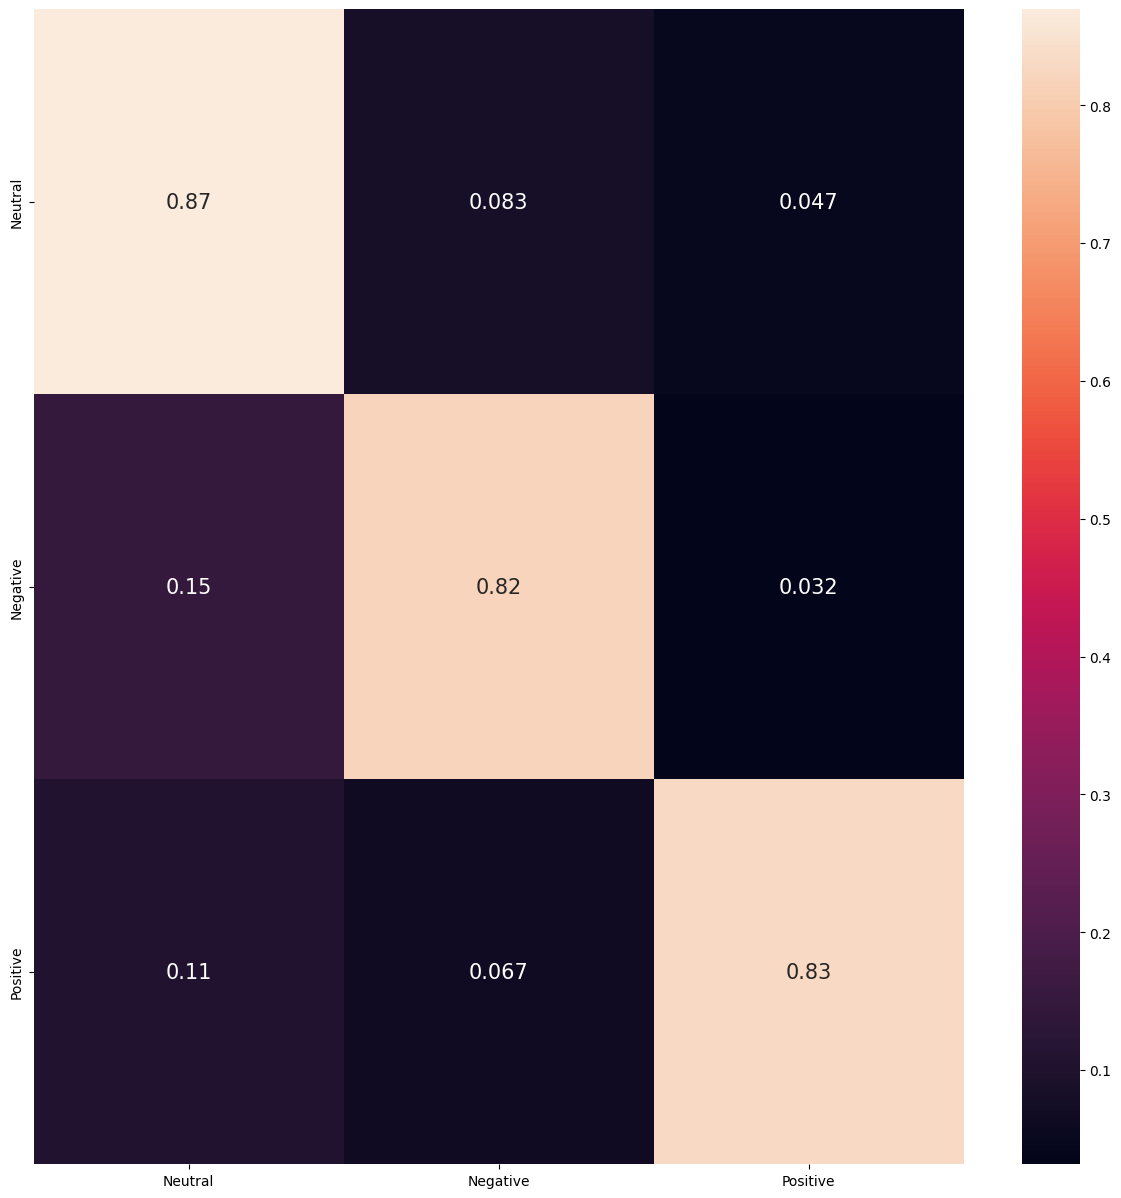

In [37]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1).to_numpy()[:, np.newaxis]
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [38]:
sentiment = ['Neutral','Negative','Positive']

In [40]:
sequence = tokenizer.texts_to_sequences(['this experience has been the worst , want my money back'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


'Negative'

In [42]:
sequence = tokenizer.texts_to_sequences(['this sounds very nice '])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


'Positive'

In [44]:

sequence = tokenizer.texts_to_sequences(['i hate twitch ads, they are annoying, fuck them '])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


'Negative'